In [73]:
##pip install --force-reinstall --no-cache-dir numpy==1.26.4 pmdarima

In [74]:
# importing the Dataset
from google.colab import files
import lightgbm as lgb
import numpy as np
import pandas as pd

from prophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

uploaded = files.upload()  # This will open a file picker
df = pd.read_csv('ADANIPORTS.csv')
temp = copy.deepcopy(df)

Saving ADANIPORTS.csv to ADANIPORTS (3).csv


In [75]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [76]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [77]:
df.dtypes

,0
Date,object
Symbol,object
Series,object
Prev Close,float64
Open,float64
High,float64
Low,float64
Last,float64
Close,float64
VWAP,float64


Data Preprocessing

In [78]:
# 'Date' column  should be datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [79]:
# Sort by Date
df.sort_values('Date', inplace=True)

In [80]:
#Drop rows with missing/invalid dates
if df['Date'].isna().sum()>0:
  df = df.dropna(subset =['Date'])

In [81]:
#drop duplicates
if df.duplicated().sum() >0:
  df.drop_dupicates(inplace=True)

In [82]:
#set date as index
df.set_index('Date',inplace=True)

In [83]:
# Create a business day date range (Mon–Fri only)
full_bd_range = pd.date_range(start =df.index.min(),end=df.index.max(),freq='B')

# reindex to business days
df = df.reindex(full_bd_range)
df.index.name ='Date'

In [84]:
# Fill missing trading days
if 'Volume' in df.columns:
    # Fill OHLC columns forward, Volume as 0
    ohlc_cols = [col for col in df.columns if col not in ['Volume']]
    df[ohlc_cols] = df[ohlc_cols].fillna(method='ffill')
    df['Volume'] = df['Volume'].fillna(0)
else:
    # If Volume not available, just forward fill everything
    df.fillna(method='ffill', inplace=True)

In [85]:
df.shape

(3504, 14)

### EDA

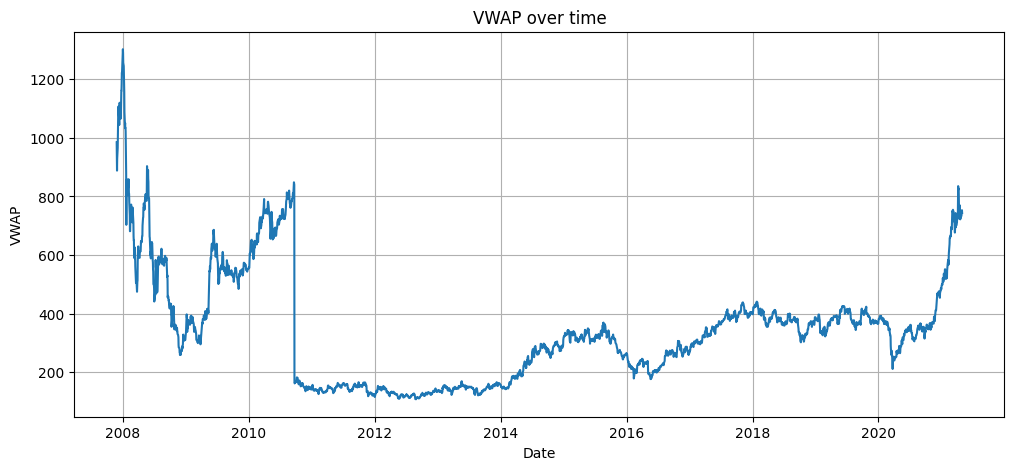

In [86]:
plt.figure(figsize = (12,5))
plt.plot(df.index,df['VWAP'])
plt.title('VWAP over time')
plt.xlabel('Date')
plt.ylabel('VWAP')
plt.grid(True)
plt.show()

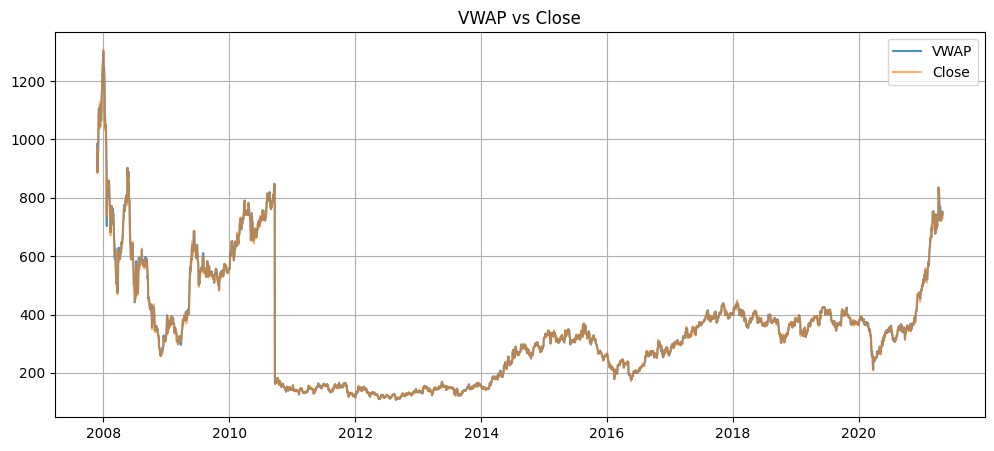

In [87]:
plt.figure(figsize=(12,5))
plt.plot(df.index,df['VWAP'],label='VWAP',alpha=0.8)
plt.plot(df.index,df['Close'],label='Close',alpha=0.6)
plt.legend()
plt.grid(True)
plt.title('VWAP vs Close')
plt.show()

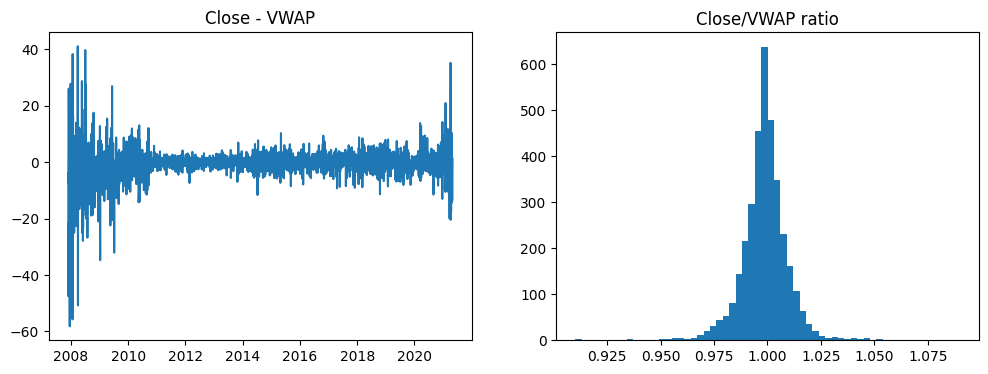

In [88]:
# VWAP-Close relationship
df['close_VWAP_Spread'] = df['Close']-df['VWAP']
df['close_to_VWAP_ratio'] = df['Close']/df['VWAP']

fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(df.index,df['close_VWAP_Spread']);ax[0].set_title('Close - VWAP')
ax[1].hist(df['close_to_VWAP_ratio'].dropna(),bins=60);ax[1].set_title('Close/VWAP ratio')
plt.show()

Left Plot – Close - VWAP Spread
We see most values hovering around 0, which is expected — VWAP should be close to Close price.

Some spikes (both positive & negative) occur:

Positive spike → Close price much higher than VWAP that day.

Negative spike → Close price much lower than VWAP that day.

These spikes could indicate high intraday volatility, gap-up/gap-down days, or bad ticks.

Inference: The spread is generally stable, but extreme spikes might require investigation — maybe compare with news or remove if they're data errors.

Right Plot – Close / VWAP Ratio
The histogram is centered tightly around 1.0, meaning Close ≈ VWAP for most days.

A small spread in distribution indicates healthy data.

If we saw ratios like 1.2 or 0.8, it would suggest unusual differences.

Inference:
The VWAP data aligns well with Close prices; no systematic drift.
Only a few outliers exist (seen as the small tails in the histogram)

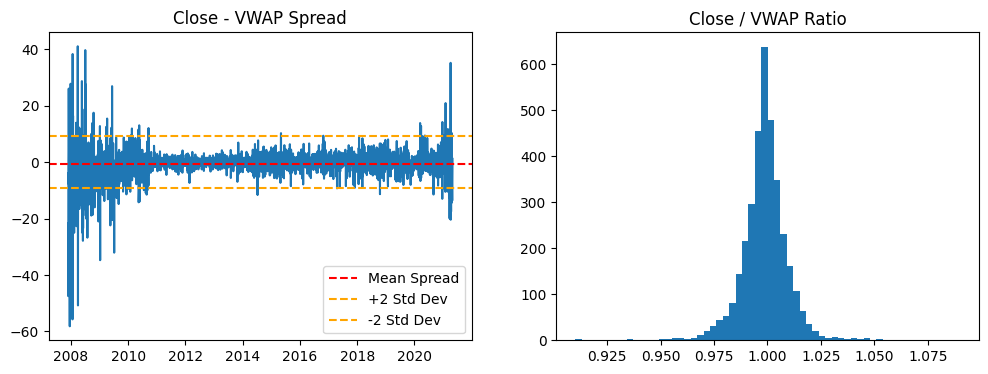

Suspicious days where Close deviates strongly from VWAP:
              Close     VWAP  close_VWAP_Spread
Date                                           
2007-11-27   962.90   984.72             -21.82
2007-11-28   893.90   941.38             -47.48
2007-12-04  1041.45  1015.39              26.06
2007-12-11  1047.65  1067.80             -20.15
2007-12-13  1129.95  1109.09              20.86
...             ...      ...                ...
2021-04-12   744.65   762.16             -17.51
2021-04-15   750.35   740.39               9.96
2021-04-16   755.50   770.01             -14.51
2021-04-22   737.80   727.53              10.27
2021-04-30   730.05   743.35             -13.30

[181 rows x 3 columns]


In [89]:
# Identify suspicious differences
# Rule: Spread beyond ±2 standard deviations is suspicious
spread_mean = df['close_VWAP_Spread'].mean()
spread_std = df['close_VWAP_Spread'].std()
threshold = spread_mean + 2 * spread_std

# Filter suspicious days
suspicious_days = df[np.abs(df['close_VWAP_Spread']) > threshold]

#  Plot spread & ratio
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Spread plot
ax[0].plot(df.index, df['close_VWAP_Spread'])
ax[0].set_title('Close - VWAP Spread')
ax[0].axhline(y=spread_mean, color='red', linestyle='--', label='Mean Spread')
ax[0].axhline(y=threshold, color='orange', linestyle='--', label='+2 Std Dev')
ax[0].axhline(y=-threshold, color='orange', linestyle='--', label='-2 Std Dev')
ax[0].legend()

# Ratio histogram
ax[1].hist(df['close_to_VWAP_ratio'].dropna(), bins=60)
ax[1].set_title('Close / VWAP Ratio')

plt.show()

#  Output suspicious days
print("Suspicious days where Close deviates strongly from VWAP:")
print(suspicious_days[[ 'Close', 'VWAP', 'close_VWAP_Spread']])

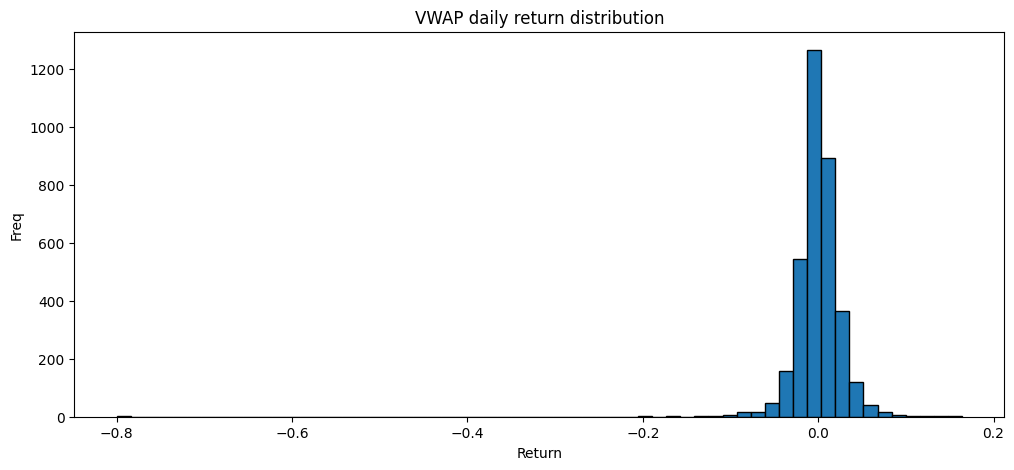

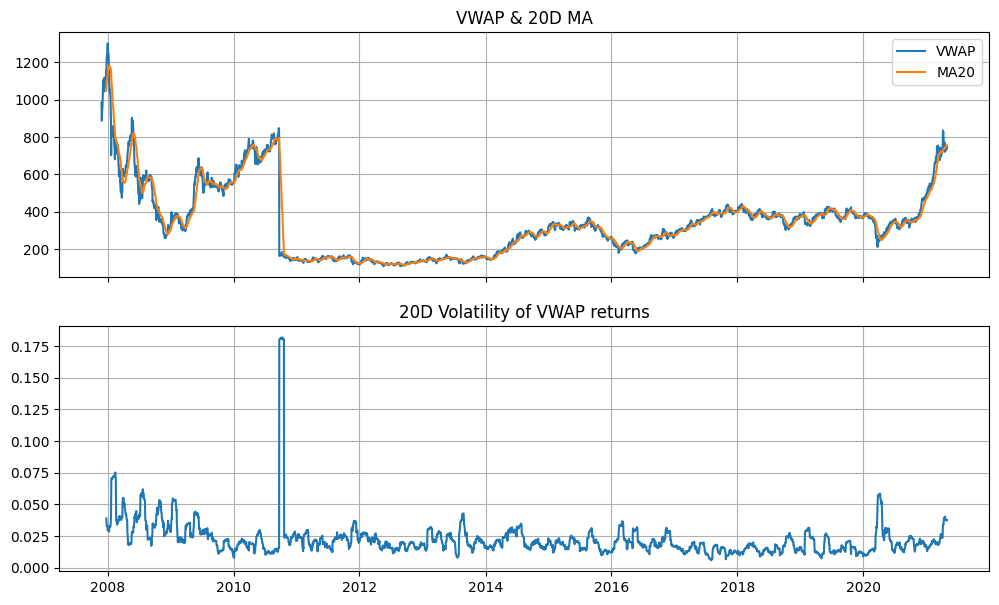

In [90]:
# return and volatility of VWAP
df['VWAP_return'] = df['VWAP'].pct_change()
df['VWAP_logret'] = np.log(df['VWAP']/df['VWAP'].shift(1))
#distribution
plt.figure(figsize=(12,5))
plt.hist(df['VWAP_return'].dropna(),bins =60 , edgecolor = 'k')
plt.title('VWAP daily return distribution');plt.xlabel('Return'),plt.ylabel('Freq');plt.show()

#rolling trend and volatility
df['VWAP_MA_20']= df['VWAP'].rolling(20).mean()
df['VWAP_Vol_20']= df['VWAP_return'].rolling(20).std()

fig,ax = plt.subplots(2,1 ,figsize=(12,7),sharex=True)
ax[0].plot(df.index,df['VWAP'],label ='VWAP');ax[0].plot(df.index,df['VWAP_MA_20'],label ='MA20')
ax[0].legend();ax[0].set_title('VWAP & 20D MA');ax[0].grid(True)
ax[1].plot(df.index, df['VWAP_Vol_20']); ax[1].set_title('20D Volatility of VWAP returns'); ax[1].grid(True)
plt.show()

1. VWAP Daily Return Distribution (Histogram)
What we see: A tall peak near 0% change and long tails on both sides.

Inference:

Most days have small changes in VWAP (clustered near zero).

The tails show rare but significant spikes/drops (possible market shocks, events, or anomalies).

Why log returns are also computed:

They handle compounding effects better.

They normalize extreme values when comparing across stocks/time.

2. VWAP & 20-Day Moving Average (First Line Chart)
What we see:

VWAP (blue) and 20-day MA (orange) move closely together.

In some periods (e.g., 2008–2009, 2020), VWAP deviates strongly from the MA — these are high volatility or trend change periods.

Inference:

When VWAP is above MA → possible uptrend.

When VWAP is below MA → possible downtrend.

The closeness of the lines in stable periods confirms low volatility.

3. 20-Day Rolling Volatility (Second Line Chart)
What we see:

Spikes in volatility during certain years (e.g., 2008 financial crisis, 2020 COVID crash).

Long stretches of low volatility in stable market phases.

Inference:

High volatility = uncertainty, risky market conditions.

Low volatility = stable, predictable conditions.

Useful for deciding risk management strategies.

The volatility jumps to ~0.175 (17.5%) which is very high compared to normal values (<5%). (spike in 2010)

This means that in that period, VWAP daily changes were swinging wildly, both upward and downward.

Possible reasons:

Corporate action like a stock split, merger, or demerger that abruptly changes the price scale.

Market shock (economic or company-specific).

Data quality issue (missing data, incorrect adjustment).

Illiquidity — if few trades happen, VWAP can jump more between trades.


Key takeaway :

We use returns to measure direction and magnitude of daily movement, and volatility to measure risk. In our data, VWAP mostly has small day-to-day changes, but certain periods (2008, 2020) have extreme volatility spikes due to market events. The moving average smooths the trend, and rolling volatility reveals time-varying risk.

In [91]:
# Outliers & anomalies
ret = df['VWAP_return']
thr = ret.std()*6
anomalies = df[ret.abs()>thr][['VWAP','VWAP_return','Volume']]
print(anomalies)

              VWAP  VWAP_return     Volume
Date                                      
2008-01-22  703.20    -0.201608   546161.0
2008-01-23  818.67     0.164206   535462.0
2010-09-23  167.86    -0.800129   854754.0
2020-03-23  211.60    -0.171593  5716818.0


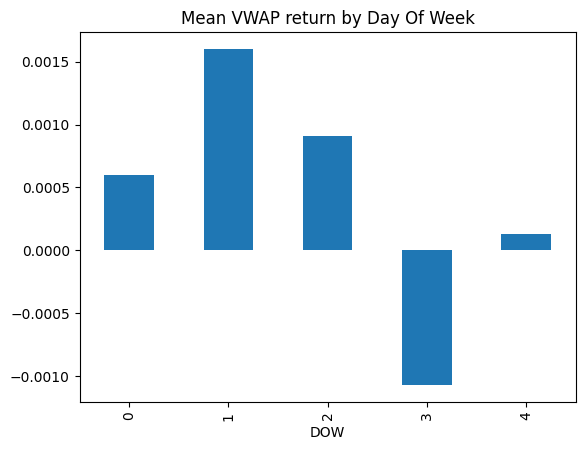

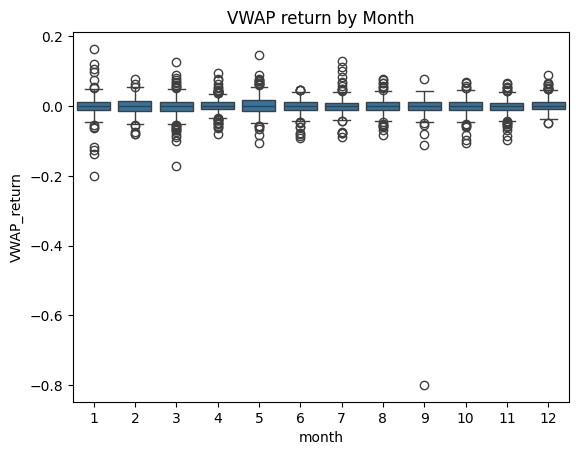

In [92]:
# Calender effects (deasonality proxies)
df['DOW'] = df.index.dayofweek
df['month'] = df.index.month

#day of the week mean return
dow_ret = df.groupby('DOW')['VWAP_return'].mean()
dow_ret.plot(kind = 'bar'); plt.title('Mean VWAP return by Day Of Week'); plt.show()

#Month of year distribution
import seaborn as sns
sns.boxplot(x='month' , y='VWAP_return', data = df.reset_index())
plt.title('VWAP return by Month'); plt.show()

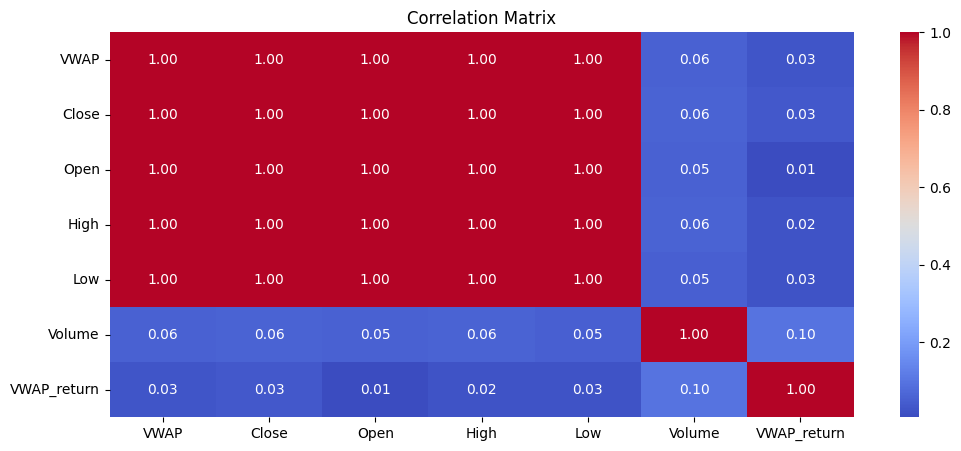

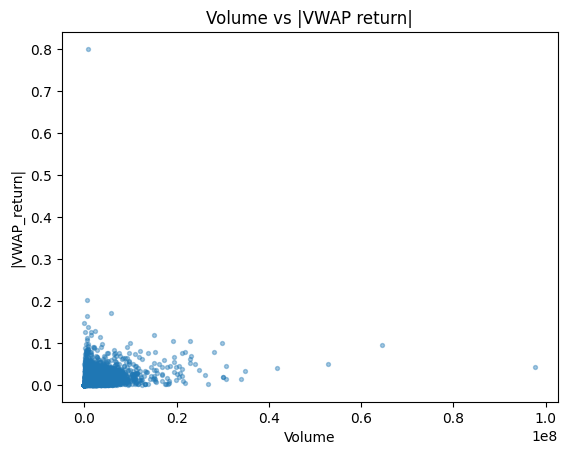

In [93]:
 # Correlation and friver of VWAP
 num = df[['VWAP','Close','Open','High','Low','Volume','VWAP_return']].dropna()
 corr = num.corr()
 plt.figure(figsize = (12,5))
 sns.heatmap(corr,annot=True,fmt='.2f', cmap = 'coolwarm')
 plt.title('Correlation Matrix');plt.show()

 #volume-Volatility
 plt.scatter(df['Volume'],df['VWAP_return'].abs(),s=8,alpha = 0.4)
 plt.xlabel('Volume');plt.ylabel('|VWAP_return|');plt.title('Volume vs |VWAP return|');plt.show()

<Figure size 1200x500 with 0 Axes>

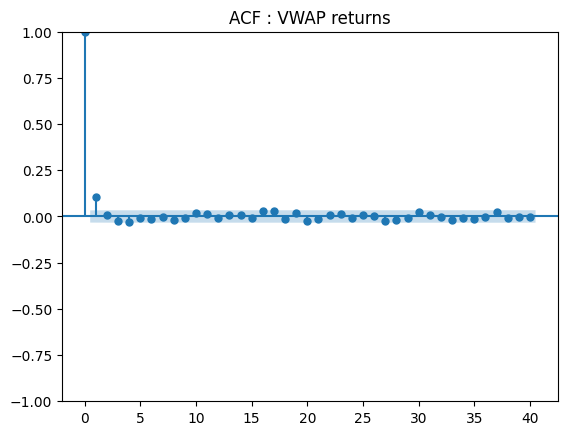

<Figure size 1200x500 with 0 Axes>

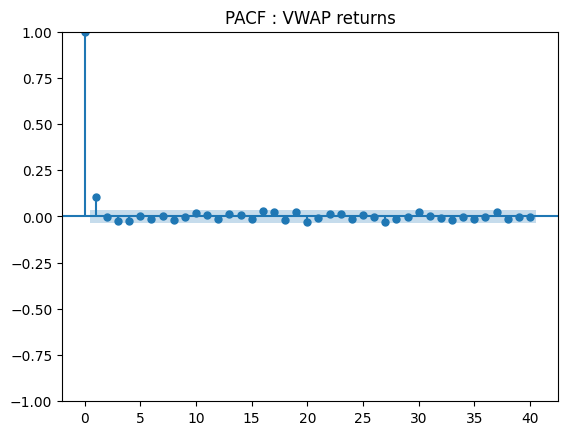

ADF VWAP: p= 0.024442197678053102  | ADF VWAP_return: p= 0.0
KPSS VWAP: p= 0.01  | KPSS VWAP_return: p= 0.1


In [94]:
# ACF/PACF & Stationarity

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss

fig =plt.figure(figsize = (12,5))
plot_acf(df['VWAP_return'].dropna(),lags=40); plt.title('ACF : VWAP returns'); plt.show()

fig =plt.figure(figsize = (12,5))
plot_pacf(df['VWAP_return'].dropna(),lags=40,method='ywm'); plt.title('PACF : VWAP returns'); plt.show()

#stationarity tests
adf_price = adfuller(df['VWAP'].dropna())
adf_ret = adfuller(df['VWAP_return'].dropna())
print('ADF VWAP: p=', adf_price[1], ' | ADF VWAP_return: p=' ,adf_ret[1])

kpss_price = kpss(df['VWAP'].dropna(), regression='c', nlags='auto')
kpss_ret   = kpss(df['VWAP_return'].dropna(), regression='c', nlags='auto')
print('KPSS VWAP: p=', kpss_price[1], ' | KPSS VWAP_return: p=', kpss_ret[1])

                   mean         std     min      max
Date                                                
2007-11-30   935.840000   39.768067  888.09   984.72
2007-12-31  1109.465238   73.367359  965.65  1277.64
2008-01-31  1027.246522  188.001780  703.20  1302.15
2008-02-29   756.741905   49.606864  681.38   858.77
2008-03-31   571.603333   67.317310  474.92   709.31
...                 ...         ...     ...      ...
2020-12-31   465.243478   16.897254  420.33   487.06
2021-01-31   522.245238   16.299804  495.57   551.88
2021-02-28   615.364500   52.581188  521.81   695.14
2021-03-31   720.970000   23.685356  676.77   754.53
2021-04-30   752.590000   36.054394  721.84   835.16

[162 rows x 4 columns]


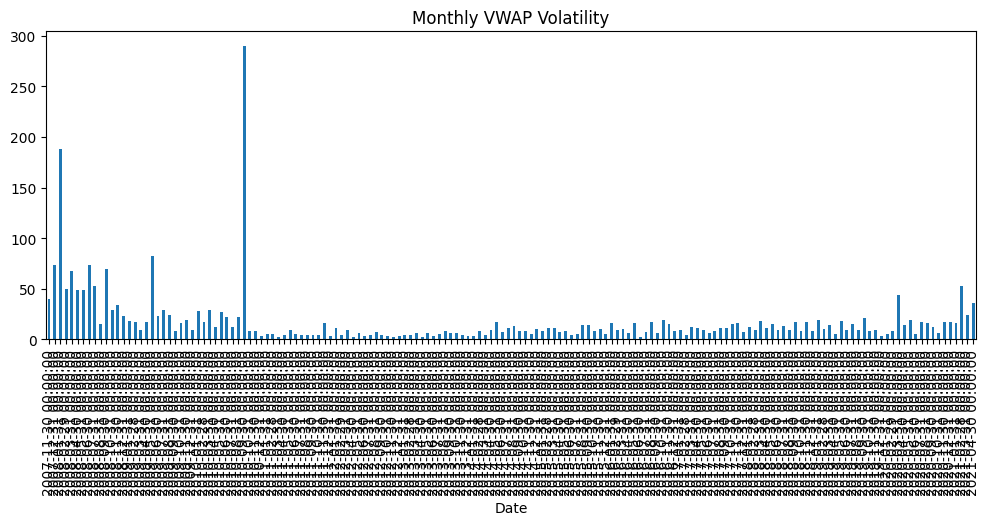

Top + days:
 Date
2008-01-23    0.164206
2009-05-18    0.147157
2008-07-09    0.128582
2008-03-28    0.126981
2009-01-05    0.119973
2008-07-10    0.113627
2013-01-29    0.105204
2014-07-02    0.099518
2009-01-12    0.097470
2021-04-06    0.096160
Name: VWAP_return, dtype: float64
Top - days:
 Date
2010-09-23   -0.800129
2008-01-22   -0.201608
2020-03-23   -0.171593
2008-01-21   -0.138670
2009-01-09   -0.126270
2019-01-28   -0.118109
2008-09-18   -0.111259
2008-10-10   -0.106351
2016-05-04   -0.105424
2020-03-12   -0.098753
Name: VWAP_return, dtype: float64


In [95]:
# Monthly/Annual Summaries

monthly = df['VWAP'].resample('M').agg(['mean','std','min','max'])
print(monthly)

monthly['std'].plot(kind='bar',figsize=(12,4),title='Monthly VWAP Volatility'); plt.show()

#best/worst days ( by return)
best = df['VWAP_return'].nlargest(10)
worst = df['VWAP_return'].nsmallest(10)
print('Top + days:\n', best)
print('Top - days:\n', worst)

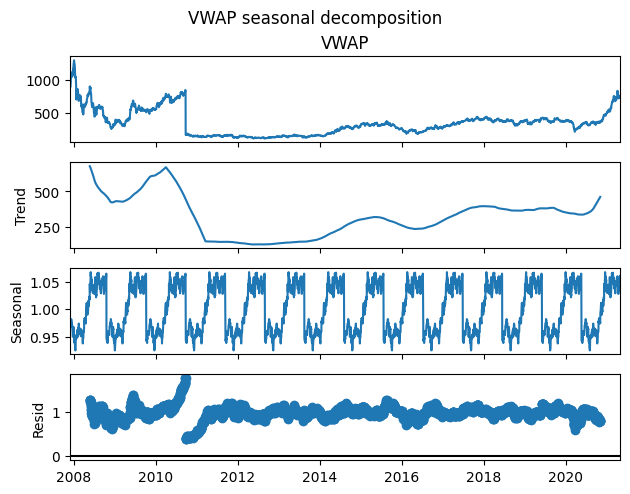

In [96]:
# Seasonal Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

dec = seasonal_decompose(df['VWAP'].dropna(),model='multiplicative',period = 252)
dec.plot(); plt.suptitle('VWAP seasonal decomposition', y=1.02); plt.show()

In [97]:
# columns we might need to model later

keep_cols = [
    'VWAP', 'Close','Open','High','Low','Volume',
    'VWAP_return','VWAP_logret','VWAP_MA_20','VWAP_Vol_20',
    'close_VWAP_Spread','close_to_VWAP_ratio','DOW','month'
]
eda_df = df[keep_cols].copy()

In [98]:
# Stationarity check

from statsmodels.tsa.stattools import adfuller,kpss
def adf_test(series,title=''):
  print(f'ADF Test : {title}')
  result = adfuller(series.dropna(), autolag = 'AIC')
  labels = ['ADF Statistic','p-value','# Lags Used','# Observations']
  for val,label in zip(result[0:4],labels):
    print(f'{label} : {val}')
  if result[1]< 0.05 :
    print("Reject null hypothesis --> Stationary")
  else:
    print("Fail to reject null hypothesis --> Non-Stationary")
  print("\n")

def kpss_test(series,title=''):
  print(f'KPSS Test : {title}')
  statistic,p_value,n_lags,critical_values = kpss(series.dropna(), regression = 'c')
  print(f'Statistic: {statistic}')
  print(f'p-value: {p_value}')
  if p_value< 0.05 :
    print("Fail to reject null hypothesis --> Non-Stationary")
  else:
    print("Reject null hypothesis --> Stationary")
  print("\n")

adf_test(df['VWAP'], 'VWAP')
kpss_test(df['VWAP'], 'VWAP')

# If non-stationary, difference the data
df['VWAP_diff'] = df['VWAP'] - df['VWAP'].shift(1)
adf_test(df['VWAP_diff'].dropna(), 'VWAP - 1st Difference')
kpss_test(df['VWAP_diff'].dropna(), 'VWAP - 1st Difference')

ADF Test : VWAP
ADF Statistic : -3.1295507346949014
p-value : 0.024442197678053102
# Lags Used : 1
# Observations : 3502
Reject null hypothesis --> Stationary


KPSS Test : VWAP
Statistic: 1.3331798173738256
p-value: 0.01
Fail to reject null hypothesis --> Non-Stationary


ADF Test : VWAP - 1st Difference
ADF Statistic : -54.15161456242545
p-value : 0.0
# Lags Used : 0
# Observations : 3502
Reject null hypothesis --> Stationary


KPSS Test : VWAP - 1st Difference
Statistic: 0.3162842768078752
p-value: 0.1
Reject null hypothesis --> Stationary




In [99]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'close_VWAP_Spread', 'close_to_VWAP_ratio',
       'VWAP_return', 'VWAP_logret', 'VWAP_MA_20', 'VWAP_Vol_20', 'DOW',
       'month', 'VWAP_diff'],
      dtype='object')

In [100]:
# feature engineering

#lags of VWAP
for lag in [1,2,3,5,10,20]:
  df[f'VWAP_LAG_{lag}'] = df['VWAP'].shift(lag)

# rolling stats
for window in [5,10,20]:
  df[f'VWAP_roll_mean_{window}'] = df['VWAP'].rolling(window = window).mean()
  df[f'VWAP_roll_std_{window}'] = df['VWAP'].rolling(window = window).std()
  df[f'VWAP_roll_min_{window}'] = df['VWAP'].rolling(window = window).min()
  df[f'VWAP_roll_max_{window}'] = df['VWAP'].rolling(window = window).max()

# rolling correlation between close and VWAP
df['close_VWAP_corr_10'] = df['Close'].rolling(window = 10).corr(df['VWAP'])

df['DOM'] = df.index.day
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)

df.dropna(inplace=True)

In [101]:
# Function to evaluate forecast performance
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [102]:
target = 'VWAP'
data = df[[target]].dropna()
train_size = int(len(data)*0.8)
train,test = data.iloc[:train_size],data.iloc[train_size:]

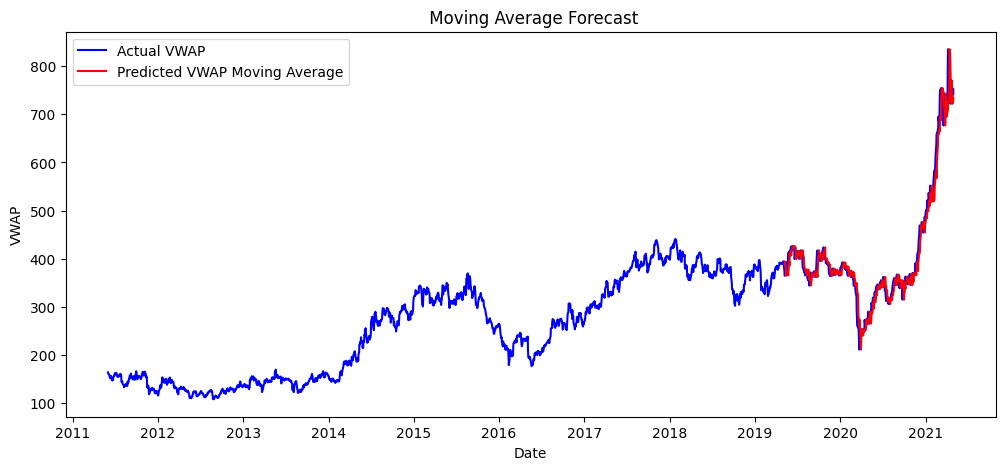

MAE: 16.2264
RMSE: 23.4691
MAPE: 3.85%


In [103]:
# Moving Average Model
import copy
ma_train = copy.copy(train)
ma_window = 5
ma_predictions = []

for i in range(len(test)):
  past_data = ma_train[target].iloc[-ma_window].mean()
  ma_predictions.append(past_data)
  ma_train = pd.concat([ma_train,test.iloc[i:i+1]]) #append actual value for rolling calc

# evalute

ma_mae, ma_rmse, ma_mape = evaluate_forecast(test[target], ma_predictions)
# ma_mae = mean_absolute_error(test[target],ma_predictions)
# ma_rmse = np.sqrt(mean_squared_error(test[target],ma_predictions))
# ma_mape = np.mean(np.abs((test[target] - ma_predictions) / test[target]))* 100

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,ma_predictions,label = 'Predicted VWAP Moving Average',color ='red')
plt.title(" Moving Average Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {ma_mae:.4f}")
print(f"RMSE: {ma_rmse:.4f}")
print(f"MAPE: {ma_mape:.2f}%")

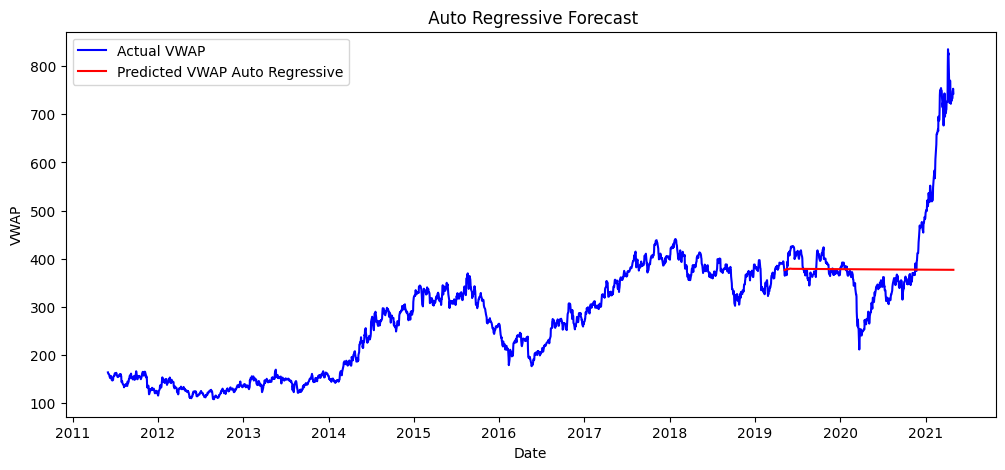

MAE: 77.2867
RMSE: 128.8947
MAPE: 16.30%
                            AutoReg Model Results                             
Dep. Variable:                   VWAP   No. Observations:                 2070
Model:                    AutoReg(20)   Log Likelihood               -6167.484
Method:               Conditional MLE   S.D. of innovations              4.902
Date:                Sat, 16 Aug 2025   AIC                          12378.967
Time:                        16:00:34   BIC                          12502.731
Sample:                    06-29-2011   HQIC                         12424.354
                         - 05-07-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3683      0.301      1.225      0.221      -0.221       0.958
VWAP.L1        1.1310      0.022     51.204      0.000       1.088       1.174
VWAP.L2    

In [104]:
# Autoregressive Model

from statsmodels.tsa.ar_model import AutoReg

'''lag selection method -- we can use pacg plot, its visual method so we are going with
automatic selection methos using AIC'''

aic_values = {}
for lag in range(1,21):
  try:
    model = AutoReg(train[target],lags=lag).fit()
    aic_values[lag] = model.aic
  except:
    continue
best_lag = min(aic_values,key = aic_values.get)

ar_model = AutoReg(train[target],lags=best_lag).fit() #fit
ar_predictions = ar_model.predict(start=test.index[0], end=test.index[-1],dynamic = False) #predict
ar_mae, ar_rmse, ar_mape = evaluate_forecast(test[target], ar_predictions) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,ar_predictions,label = 'Predicted VWAP Auto Regressive',color ='red')
plt.title(" Auto Regressive Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {ar_mae:.4f}")
print(f"RMSE: {ar_rmse:.4f}")
print(f"MAPE: {ar_mape:.2f}%")
print(ar_model.summary())

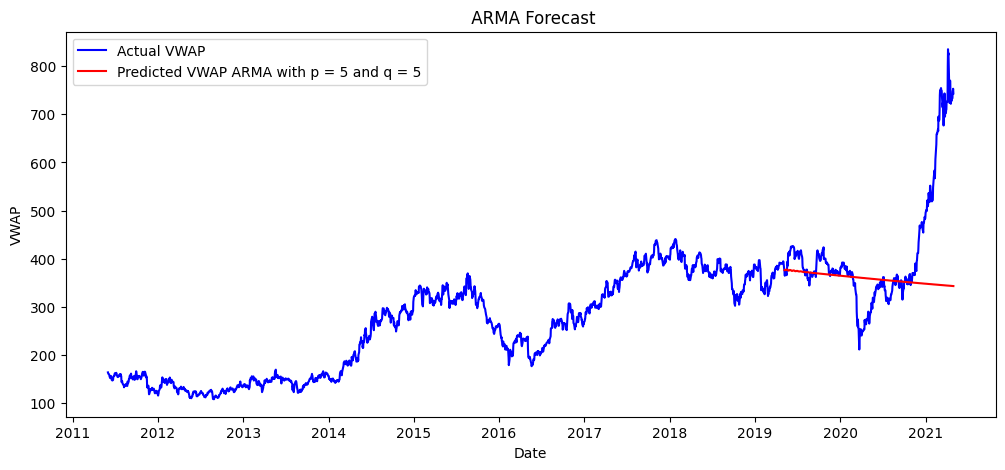

MAE: 78.6416
RMSE: 139.5288
MAPE: 15.64%
                               SARIMAX Results                                
Dep. Variable:                   VWAP   No. Observations:                 2070
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -6223.265
Date:                Sat, 16 Aug 2025   AIC                          12470.530
Time:                        16:04:50   BIC                          12538.154
Sample:                    06-01-2011   HQIC                         12495.317
                         - 05-07-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        253.6734    209.327      1.212      0.226    -156.600     663.947
ar.L1          1.2433      0.043     28.797      0.000       1.159       1.328
ar.L2      

In [105]:
# ARMA model

from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None
for p in range(1,6):
  for q in range(1,6):
    try:
      model = ARIMA(train[target],order=(p,0,q)).fit()
      if model.aic < best_aic:
        best_aic = model.aic
        best_order = (p,q)
    except:
      continue

  p,q = best_order
  arma_model = ARIMA(train[target],order=(p,0,q)).fit()
  arma_predictions = arma_model.predict(start=test.index[0], end=test.index[-1])

  arma_mae, arma_rmse, arma_mape = evaluate_forecast(test[target], arma_predictions) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,arma_predictions,label = f'Predicted VWAP ARMA with p = {p} and q = {q}',color ='red')
plt.title(" ARMA Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {arma_mae:.4f}")
print(f"RMSE: {arma_rmse:.4f}")
print(f"MAPE: {arma_mape:.2f}%")
print(arma_model.summary())

ADF Statistics: -1.0166808480354879
p-value: 0.747131830467934
Critical Value 1% : -3.433523754414949
Critical Value 5% : -2.8629420173334506
Critical Value 10% : -2.5675163701450834
Series is likely non-stationary → Differencing needed.


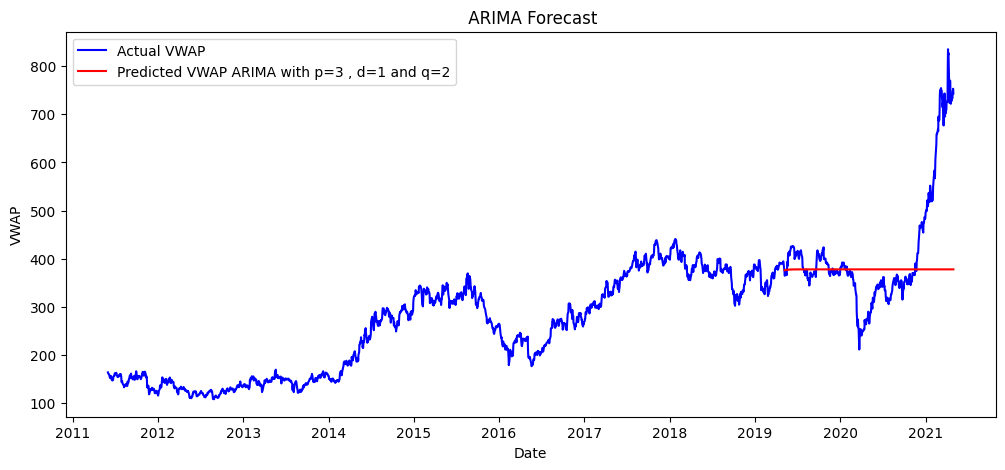

MAE: 77.2358
RMSE: 128.6212
MAPE: 16.30%
                               SARIMAX Results                                
Dep. Variable:                   VWAP   No. Observations:                 2070
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -6224.723
Date:                Sat, 16 Aug 2025   AIC                          12461.446
Time:                        16:06:23   BIC                          12495.255
Sample:                    06-01-2011   HQIC                         12473.838
                         - 05-07-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0760      0.041      1.876      0.061      -0.003       0.155
ar.L2          0.9200      0.039     23.379      0.000       0.843       0.997
ar.L3      

In [106]:
# ARIMA Model

adf_result = adfuller(train[target])
print('ADF Statistics:',adf_result[0])
print('p-value:',adf_result[1])
for key,value in adf_result[4].items():
  print(f'Critical Value {key} : {value}')
if adf_result[1]>0.05:
  print("Series is likely non-stationary → Differencing needed.")
else:
    print("Series is likely stationary.")

best_aic = np.inf
best_order = None
for p in range(0,4):
  for d in range(0,2):
      for q in range(0,4):
        try:
          model = ARIMA(train[target],order=(p,d,q)).fit()
          if model.aic < best_aic:
            best_aic = model.aic
            best_order = (p,d,q)
        except:
          continue

p,d,q = best_order
arima_model = ARIMA(train[target],order=(p,d,q)).fit()
arima_predictions = arima_model.predict(start=test.index[0], end=test.index[-1])

arima_mae, arima_rmse, arima_mape = evaluate_forecast(test[target], arima_predictions) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,arima_predictions,label = f'Predicted VWAP ARIMA with p={p} , d={d} and q={q}',color ='red')
plt.title(" ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {arima_mae:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAPE: {arima_mape:.2f}%")
print(arima_model.summary())

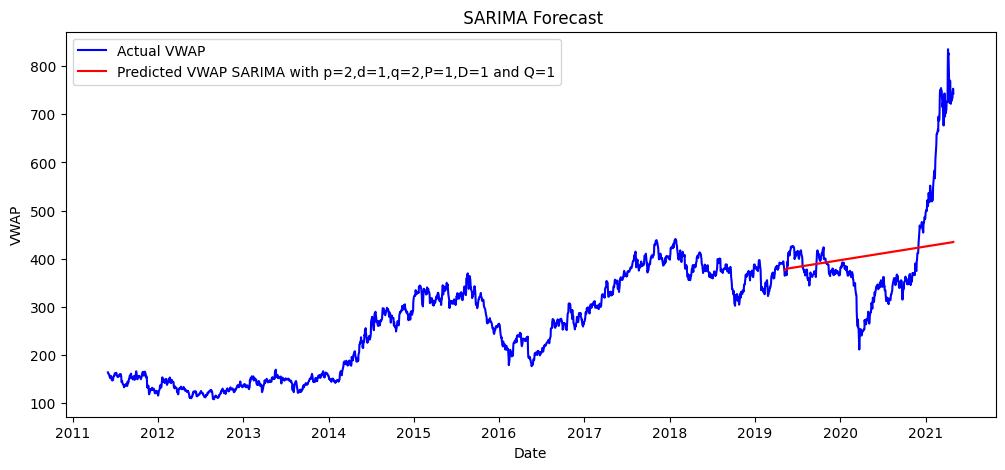

MAE: 80.7728
RMSE: 116.3721
MAPE: 18.87%
                                      SARIMAX Results                                      
Dep. Variable:                                VWAP   No. Observations:                 2070
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 5)   Log Likelihood               -6205.339
Date:                             Sat, 16 Aug 2025   AIC                          12422.679
Time:                                     16:11:18   BIC                          12456.450
Sample:                                 06-01-2011   HQIC                         12435.062
                                      - 05-07-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2018      0.121      9.910      0.000       0.96

In [107]:
# Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_period = 5

best_aic = np.inf
best_order = None
best_seasonal_order = None

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 2):
                for D in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            model = SARIMAX(train[target],
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, seasonal_period),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            results = model.fit(disp=False)
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_order = (p, d, q)
                                best_seasonal_order = (P, D, Q, seasonal_period)
                        except:
                            continue



sarima_model = SARIMAX(train[target],
                       order=best_order,
                       seasonal_order=best_seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit()


sarima_predictions = sarima_model.predict(start=test.index[0], end=test.index[-1])

sarima_mae, sarima_rmse, sarima_mape = evaluate_forecast(test[target], sarima_predictions) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,sarima_predictions,label = f'Predicted VWAP SARIMA with p={p},d={d},q={q},P={P},D={D} and Q={Q}',color ='red')
plt.title(" SARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {sarima_mae:.4f}")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"MAPE: {sarima_mape:.2f}%")
print(sarima_model.summary())


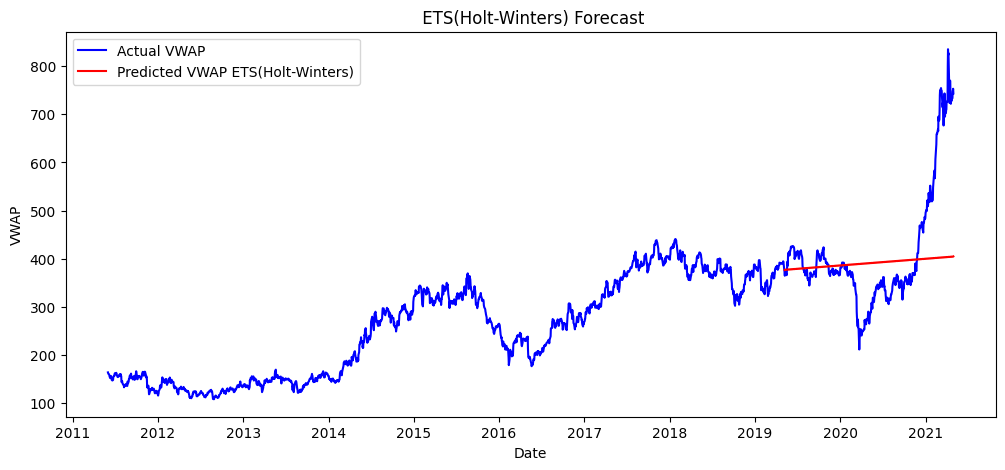

MAE: 78.2478
RMSE: 121.8595
MAPE: 17.32%
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     VWAP   No. Observations:                 2070
Model:             ExponentialSmoothing   SSE                          50922.856
Optimized:                         True   AIC                           6647.720
Trend:                         Additive   BIC                           6698.438
Seasonal:                      Additive   AICC                          6647.848
Seasonal Periods:                     5   Date:                 Sat, 16 Aug 2025
Box-Cox:                          False   Time:                         16:11:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha      

In [108]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_period =5
ets_model = ExponentialSmoothing(train[target],trend='add',seasonal = 'add', seasonal_periods=seasonal_period).fit()
ets_predictions = ets_model.predict(start = test.index[0], end =test.index[-1])

ets_mae, ets_rmse, ets_mape = evaluate_forecast(test[target], ets_predictions) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,ets_predictions,label = f'Predicted VWAP ETS(Holt-Winters)',color ='red')
plt.title(" ETS(Holt-Winters) Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {ets_mae:.4f}")
print(f"RMSE: {ets_rmse:.4f}")
print(f"MAPE: {ets_mape:.2f}%")
print(ets_model.summary())


In [109]:
df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'close_VWAP_Spread', 'close_to_VWAP_ratio',
       'VWAP_return', 'VWAP_logret', 'VWAP_MA_20', 'VWAP_Vol_20', 'DOW',
       'month', 'VWAP_diff', 'VWAP_LAG_1', 'VWAP_LAG_2', 'VWAP_LAG_3',
       'VWAP_LAG_5', 'VWAP_LAG_10', 'VWAP_LAG_20', 'VWAP_roll_mean_5',
       'VWAP_roll_std_5', 'VWAP_roll_min_5', 'VWAP_roll_max_5',
       'VWAP_roll_mean_10', 'VWAP_roll_std_10', 'VWAP_roll_min_10',
       'VWAP_roll_max_10', 'VWAP_roll_mean_20', 'VWAP_roll_std_20',
       'VWAP_roll_min_20', 'VWAP_roll_max_20', 'close_VWAP_corr_10', 'DOM',
       'is_month_start', 'is_month_end'],
      dtype='object')

Dropped highly correlated columns: ['Close', 'VWAP_roll_mean_5', 'VWAP_LAG_1', 'VWAP_LAG_2', 'VWAP_LAG_3']
Differencing applied: {'VWAP': 1, 'VWAP_return': 0, 'close_VWAP_Spread': 0, 'VWAP_roll_std_5': 0}
Selected lag order: 4


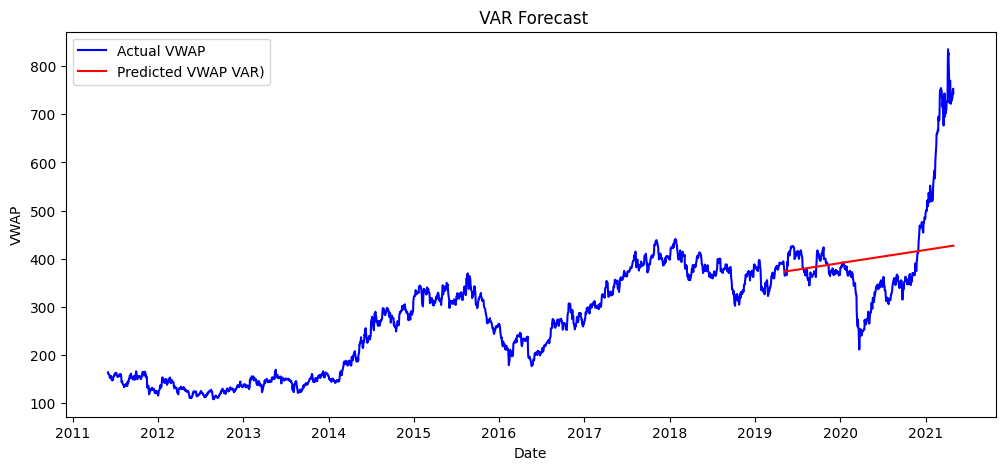

MAE: 79.1977
RMSE: 117.1005
MAPE: 18.17%


In [110]:
# VAR model trial 1
from statsmodels.tsa.api import VAR

def check_stationarity(series, cutoff=0.05):
    """ADF test for stationarity"""
    result = adfuller(series.dropna())
    return result[1] < cutoff  # p-value < cutoff => stationary

def difference_until_stationary(df):
    """Difference columns until all are stationary"""
    diff_df = df.copy()
    diff_count = {col: 0 for col in diff_df.columns}

    for col in diff_df.columns:
        while not check_stationarity(diff_df[col]):
            diff_df[col] = diff_df[col].diff()
            diff_count[col] += 1
    diff_df.dropna(inplace=True)
    return diff_df, diff_count

def drop_highly_correlated(df, threshold=0.95):
    """Drop columns with high correlation"""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

# VAR is multivariate. doesn't work for univariate so taking multiple variables

var_features = [
    'VWAP', 'VWAP_return', 'Close', 'close_VWAP_Spread',
    'VWAP_roll_mean_5', 'VWAP_roll_std_5',
    'VWAP_LAG_1', 'VWAP_LAG_2', 'VWAP_LAG_3'
]

df_var = df[var_features].dropna()

# Drop highly correlated vars
df_var, dropped_cols = drop_highly_correlated(df_var)
print(f"Dropped highly correlated columns: {dropped_cols}")

var_train_size = int(len(df_var) * 0.8)
var_train, var_test = df_var.iloc[:var_train_size], df_var.iloc[var_train_size:]

train_stationary, diff_counts = difference_until_stationary(var_train)
print(f"Differencing applied: {diff_counts}")

model = VAR(train_stationary)

try:
    selected_lag = model.select_order(maxlags=5)
    lag_order = selected_lag.aic
except:
    lag_order = 2  # fallback
print(f"Selected lag order: {lag_order}")

var_model = model.fit(lag_order)

forecast_steps = len(var_test)
var_forecast = var_model.forecast(train_stationary.values, steps=forecast_steps)

# 5. Convert forecast to DataFrame
forecast_df = pd.DataFrame(var_forecast, index=var_test.index, columns=train_stationary.columns)

def reverse_difference(last_observed, forecast_values, diff_times):
    """Reverse differencing given the last observed value and forecasted diff"""
    series = [last_observed]
    for val in forecast_values:
        series.append(series[-1] + val)
    return series[1:]

if diff_counts['VWAP'] > 0:
    last_vwap = var_train['VWAP'].iloc[-1]
    forecast_df['VWAP'] = reverse_difference(last_vwap, forecast_df['VWAP'].values, diff_counts['VWAP'])

var_mae, var_rmse, var_mape = evaluate_forecast(var_test['VWAP'], forecast_df['VWAP']) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(df_var.index,df_var['VWAP'],label = 'Actual VWAP',color ='blue')
plt.plot(var_test.index,forecast_df['VWAP'],label = f'Predicted VWAP VAR)',color ='red')
plt.title(" VAR Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {var_mae:.4f}")
print(f"RMSE: {var_rmse:.4f}")
print(f"MAPE: {var_mape:.2f}%")


Dropping highly correlated cols: ['Close', 'VWAP_roll_mean_5']
Differencing applied: {'VWAP': 1, 'VWAP_return': 0, 'close_VWAP_Spread': 0, 'VWAP_roll_std_5': 0}
Selected lag order: 2


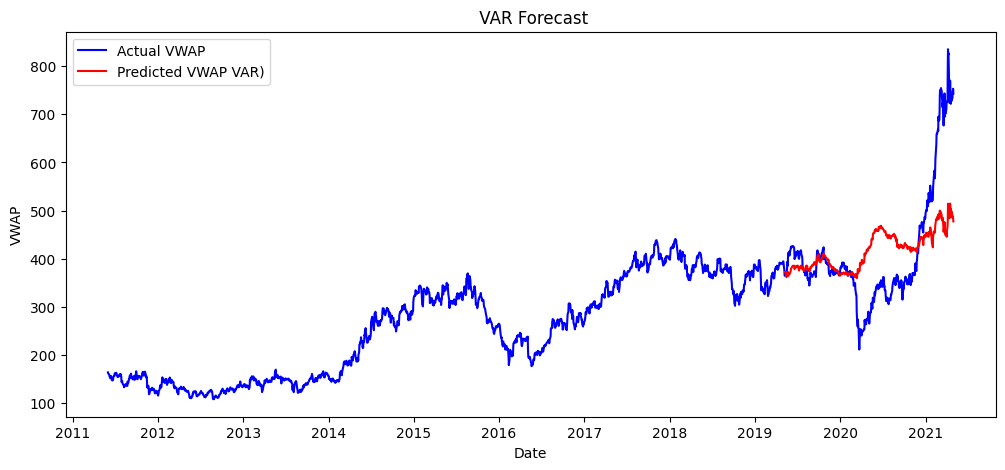

MAE: 76.2708
RMSE: 106.5201
MAPE: 18.62%


In [111]:
# VAR model trial 2
from statsmodels.tsa.api import VAR

# VAR is multivariate. doesn't work for univariate so taking multiple variables

var_features = [
    'VWAP', 'VWAP_return', 'Close', 'close_VWAP_Spread',
    'VWAP_roll_mean_5', 'VWAP_roll_std_5',
]

df_var = df[var_features].dropna()

# Drop high correlation cols
corr_matrix = df_var.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print("Dropping highly correlated cols:", high_corr)
df_var = df_var.drop(columns=high_corr)

var_train_size = int(len(df_var) * 0.8)
var_train, var_test = df_var.iloc[:var_train_size], df_var.iloc[var_train_size:]

# Check stationarity and difference only if needed
# ----------------------------
def make_stationary(data):
    diffed = {}
    new_df = data.copy()
    for col in data.columns:
        pval = adfuller(data[col])[1]
        if pval > 0.05:  # Non-stationary
            new_df[col] = new_df[col].diff()
            diffed[col] = 1
        else:
            diffed[col] = 0
    new_df = new_df.dropna()
    return new_df, diffed

train_stat, diff_info = make_stationary(var_train)
print("Differencing applied:", diff_info)

# Align test set after differencing
test_stat = var_test.copy()
for col, d in diff_info.items():
    if d == 1:
        test_stat[col] = var_test[col].diff()
test_stat = test_stat.dropna()

model = VAR(train_stat)
selected_lag = model.select_order(maxlags=3)
lag_order = selected_lag.selected_orders['aic']
print("Selected lag order:", lag_order)

var_model = model.fit(lag_order)

# Iterative forecasting
# ----------------------------
history = train_stat.values.copy()
predictions = []

for t in range(len(test_stat)):
    forecast_input = history[-lag_order:]
    yhat = var_model.forecast(y=forecast_input, steps=1)
    predictions.append(yhat[0])
    history = np.vstack([history, test_stat.values[t]])

forecast_df = pd.DataFrame(predictions, index=test_stat.index, columns=train_stat.columns)

# If differenced, reverse transformation for VWAP
# ----------------------------
vwap_pred = forecast_df['VWAP'].copy()

if diff_info['VWAP'] == 1:
    # Start from last known VWAP in train
    last_actual = var_train['VWAP'].iloc[-1]
    vwap_pred = vwap_pred.cumsum() + last_actual

var_mae, var_rmse, var_mape = evaluate_forecast(var_test['VWAP'][-len(vwap_pred):], vwap_pred) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(df_var.index,df_var['VWAP'],label = 'Actual VWAP',color ='blue')
plt.plot(vwap_pred.index,vwap_pred,label = f'Predicted VWAP VAR)',color ='red')
plt.title(" VAR Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {var_mae:.4f}")
print(f"RMSE: {var_rmse:.4f}")
print(f"MAPE: {var_mape:.2f}%")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=12483.635, Time=4.91 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=24886.305, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=20168.035, Time=3.88 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=29087.002, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[5] intercept   : AIC=12484.779, Time=2.76 sec
 ARIMA(2,0,2)(1,0,0)[5] intercept   : AIC=12484.765, Time=2.70 sec
 ARIMA(2,0,2)(2,0,1)[5] intercept   : AIC=12483.198, Time=9.12 sec
 ARIMA(2,0,2)(2,0,0)[5] intercept   : AIC=12483.269, Time=4.06 sec
 ARIMA(2,0,2)(2,0,2)[5] intercept   : AIC=12484.620, Time=13.93 sec
 ARIMA(2,0,2)(1,0,2)[5] intercept   : AIC=12483.085, Time=9.52 sec
 ARIMA(2,0,2)(0,0,2)[5] intercept   : AIC=12483.381, Time=4.95 sec
 ARIMA(1,0,2)(1,0,2)[5] intercept   : AIC=12481.114, Time=7.05 sec
 ARIMA(1,0,2)(0,0,2)[5] intercept   : AIC=12481.442, Time=2.63 sec
 ARIMA(1,0,2)(1,0,1)[5] 

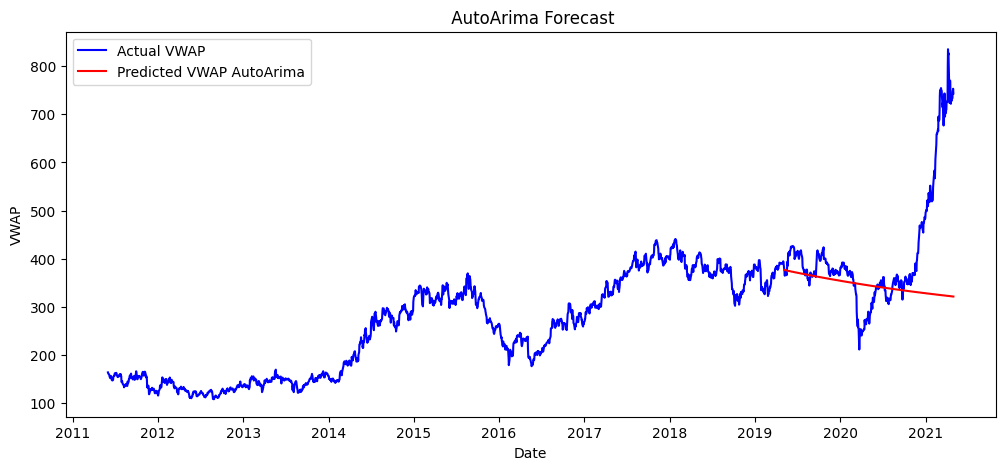

MAE: 84.3162
RMSE: 147.7231
MAPE: 16.51%


In [112]:
from pmdarima import auto_arima

auto_model = auto_model = auto_arima(train[target], seasonal = True,m=5,stepwise =True,
                        suppress_warnings=True,error_action='ignore',trace =True,d=0,    max_p=5,              # allow more AR terms
    max_q=5,              # allow more MA terms
    max_P=2,              # seasonal AR
    max_Q=2,              # seasonal MA
    )
print("Best model order:", auto_model.order)
print("Best seasonal order:", auto_model.seasonal_order)

n_periods = len(test)
auto_forecast = auto_model.predict(n_periods = n_periods)

a_arima_mae, a_arima_rmse, a_arima_mape = evaluate_forecast(test[target],auto_forecast ) #evaluate

# plot
plt.figure(figsize = (12,5))
plt.plot(data.index,data[target],label = 'Actual VWAP',color ='blue')
plt.plot(test.index,auto_forecast,label = f'Predicted VWAP AutoArima',color ='red')
plt.title(" AutoArima Forecast")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {a_arima_mae:.4f}")
print(f"RMSE: {a_arima_rmse:.4f}")
print(f"MAPE: {a_arima_mape:.2f}%")


In [113]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,...,VWAP_roll_min_10,VWAP_roll_max_10,VWAP_roll_mean_20,VWAP_roll_std_20,VWAP_roll_min_20,VWAP_roll_max_20,close_VWAP_corr_10,DOM,is_month_start,is_month_end
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-01,MUNDRAPORT,EQ,161.45,162.10,165.70,161.25,163.50,164.00,164.08,2574106.0,...,145.79,164.08,144.7170,10.570468,129.08,164.08,0.984807,1,1,0
2011-06-02,MUNDRAPORT,EQ,164.00,164.00,165.15,160.15,161.15,161.25,162.17,1699298.0,...,148.03,164.08,146.2885,10.718453,129.08,164.08,0.986155,2,0,0
2011-06-03,MUNDRAPORT,EQ,161.25,161.50,162.80,159.20,161.00,161.05,161.02,1185817.0,...,149.38,164.08,147.8855,10.394067,131.27,164.08,0.984796,3,0,0
2011-06-06,MUNDRAPORT,EQ,161.05,160.50,161.10,159.05,160.00,159.85,160.09,546378.0,...,150.59,164.08,149.3265,9.957915,133.72,164.08,0.981520,6,0,0
2011-06-07,MUNDRAPORT,EQ,159.85,159.85,162.75,156.35,157.00,157.25,158.52,2193466.0,...,150.59,164.08,150.5535,9.467218,133.72,164.08,0.973429,7,0,0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp9i6heje1/1gplu300.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9i6heje1/r0an606k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36778', 'data', 'file=/tmp/tmp9i6heje1/1gplu300.json', 'init=/tmp/tmp9i6heje1/r0an606k.json', 'output', 'file=/tmp/tmp9i6heje1/prophet_modelbcvxu734/prophet_model-20250816161418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:14:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


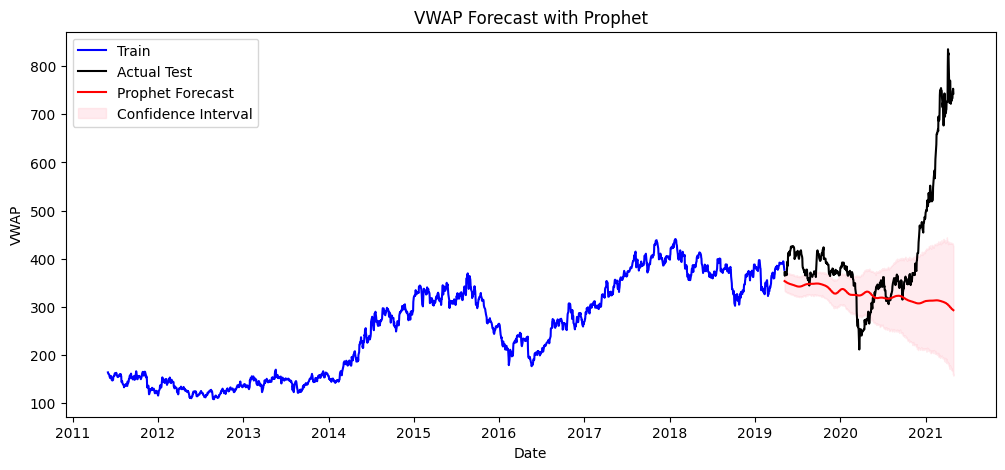

MAE: 97.1667
RMSE: 156.5177
MAPE: 19.33%


In [114]:
# Prophet model trial 1
df1 = df.copy()
prophet_df = df1.reset_index()[['Date','VWAP']].rename(columns={'Date':'ds','VWAP':'y'})

prophet_train_size = int(len(prophet_df)* 0.8)
train_df = prophet_df.iloc[:prophet_train_size]
test_df = prophet_df.iloc[prophet_train_size:]

ph_model = Prophet(yearly_seasonality = True,weekly_seasonality = False,daily_seasonality=False,seasonality_mode = 'additive')
ph_model.fit(train_df)
future = ph_model.make_future_dataframe(periods=len(test_df),freq='D')
ph_forecast = ph_model.predict(future)

ph_forecast_test = ph_forecast.iloc[-len(test_df):]

ph_mae, ph_rmse, ph_mape = evaluate_forecast(test_df['y'],ph_forecast_test['yhat'] ) #evaluate

# plot
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Actual Test', color='black')
plt.plot(test_df['ds'], ph_forecast_test['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(test_df['ds'], ph_forecast_test['yhat_lower'], ph_forecast_test['yhat_upper'],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("VWAP Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {ph_mae:.4f}")
print(f"RMSE: {ph_rmse:.4f}")
print(f"MAPE: {ph_mape:.2f}%")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9i6heje1/ecq53dov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9i6heje1/xafqha83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77583', 'data', 'file=/tmp/tmp9i6heje1/ecq53dov.json', 'init=/tmp/tmp9i6heje1/xafqha83.json', 'output', 'file=/tmp/tmp9i6heje1/prophet_model6cbse2tk/prophet_model-20250816161420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


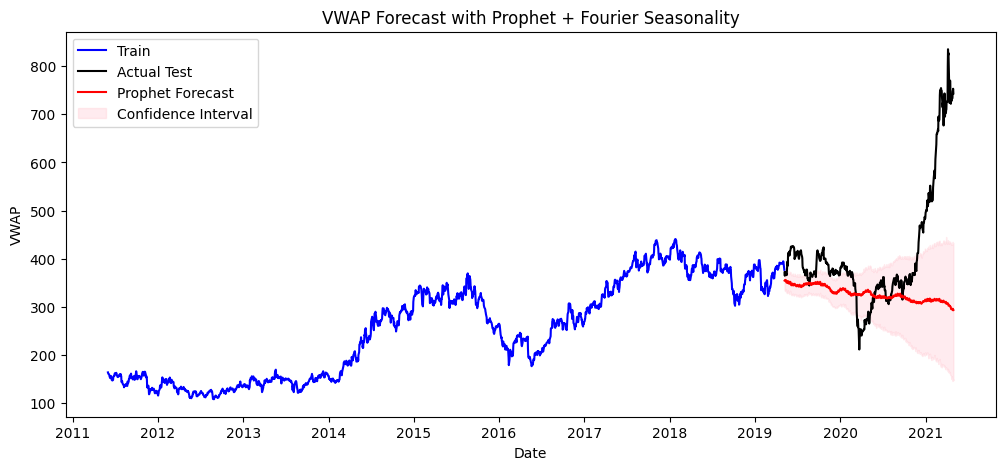

MAE: 96.6205
RMSE: 156.1754
MAPE: 19.21%


In [115]:
# Prophet model trial 2
df1 = df.copy()
prophet_df = df1.reset_index()[['Date','VWAP']].rename(columns={'Date':'ds','VWAP':'y'})

prophet_train_size = int(len(prophet_df)* 0.8)
train_df = prophet_df.iloc[:prophet_train_size]
test_df = prophet_df.iloc[prophet_train_size:]

ph_model = Prophet(yearly_seasonality = True,weekly_seasonality = False,daily_seasonality=False,seasonality_mode = 'additive')

# Add custom Fourier terms
# Yearly pattern
ph_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
# Monthly pattern
ph_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
# Weekly pattern (optional)
ph_model.add_seasonality(name='weekly', period=7, fourier_order=3)

ph_model.fit(train_df)
future = ph_model.make_future_dataframe(periods=len(test_df),freq='D')
ph_forecast = ph_model.predict(future)

ph_forecast_test = ph_forecast.iloc[-len(test_df):]

ph_mae, ph_rmse, ph_mape = evaluate_forecast(test_df['y'],ph_forecast_test['yhat'] ) #evaluate

# plot
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Actual Test', color='black')
plt.plot(test_df['ds'], ph_forecast_test['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(test_df['ds'], ph_forecast_test['yhat_lower'], ph_forecast_test['yhat_upper'],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("VWAP Forecast with Prophet + Fourier Seasonality")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

print(f"MAE: {ph_mae:.4f}")
print(f"RMSE: {ph_rmse:.4f}")
print(f"MAPE: {ph_mape:.2f}%")

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.876081	valid_1's rmse: 99.2289
[200]	training's rmse: 0.395174	valid_1's rmse: 98.7874
Early stopping, best iteration is:
[167]	training's rmse: 0.452175	valid_1's rmse: 98.769
MAE: 39.0621
RMSE: 98.7690
MAPE: 5.89%


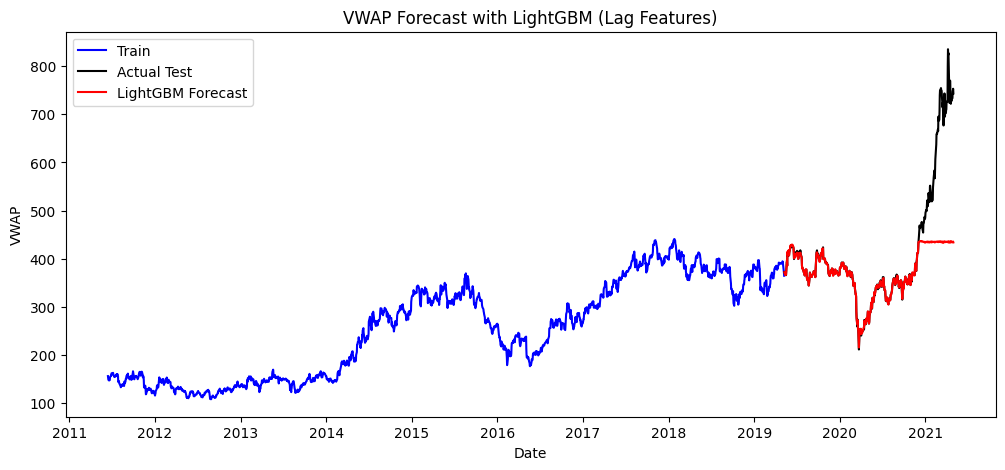

In [116]:
# lightgbm

lgb_df = df.copy().reset_index()
lgb_df.rename(columns={'Date':'date'},inplace=True)
lgb_df=lgb_df.drop(columns=['Symbol', 'Series'])

# Feature engineering: lag features
max_lag = 10  # how many past days to use
for lag in range(1, max_lag + 1):
    lgb_df[f'lag_{lag}'] = lgb_df['VWAP'].shift(lag)

# Rolling mean & std
lgb_df['roll_mean_3'] = lgb_df['VWAP'].shift(1).rolling(window=3).mean()
lgb_df['roll_std_3'] = lgb_df['VWAP'].shift(1).rolling(window=3).std()

lgb_df['roll_mean_7'] = lgb_df['VWAP'].shift(1).rolling(window=7).mean()
lgb_df['roll_std_7'] = lgb_df['VWAP'].shift(1).rolling(window=7).std()

# Drop NA rows from lagging
lgb_df = lgb_df.dropna().reset_index(drop=True)

# Train-test split
train_size1 = int(len(lgb_df) * 0.8)
train1 = lgb_df.iloc[:train_size1]
test1 = lgb_df.iloc[train_size1:]

X_train = train1.drop(columns=['date', 'VWAP'])
y_train = train1['VWAP']
X_test = test1.drop(columns=['date', 'VWAP'])
y_test = test1['VWAP']

# LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)  # replaces verbose_eval=100
    ]

)

# Predict
y_pred = lgb_model.predict(X_test)

# Evaluate
lbg_mae = mean_absolute_error(y_test, y_pred)
lbg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lbg_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {lbg_mae:.4f}")
print(f"RMSE: {lbg_rmse:.4f}")
print(f"MAPE: {lbg_mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train1['date'], y_train, label='Train', color='blue')
plt.plot(test1['date'], y_test, label='Actual Test', color='black')
plt.plot(test1['date'], y_pred, label='LightGBM Forecast', color='red')
plt.title("VWAP Forecast with LightGBM (Lag Features)")
plt.xlabel("Date")
plt.ylabel("VWAP")
plt.legend()
plt.show()

In [123]:
temp.set_index("Date", drop=False, inplace=True)
temp['Date'] = pd.to_datetime(temp['Date'], format = '%Y-%m-%d')
temp=temp.drop(columns=['Symbol', 'Series'])

<Axes: xlabel='Date'>

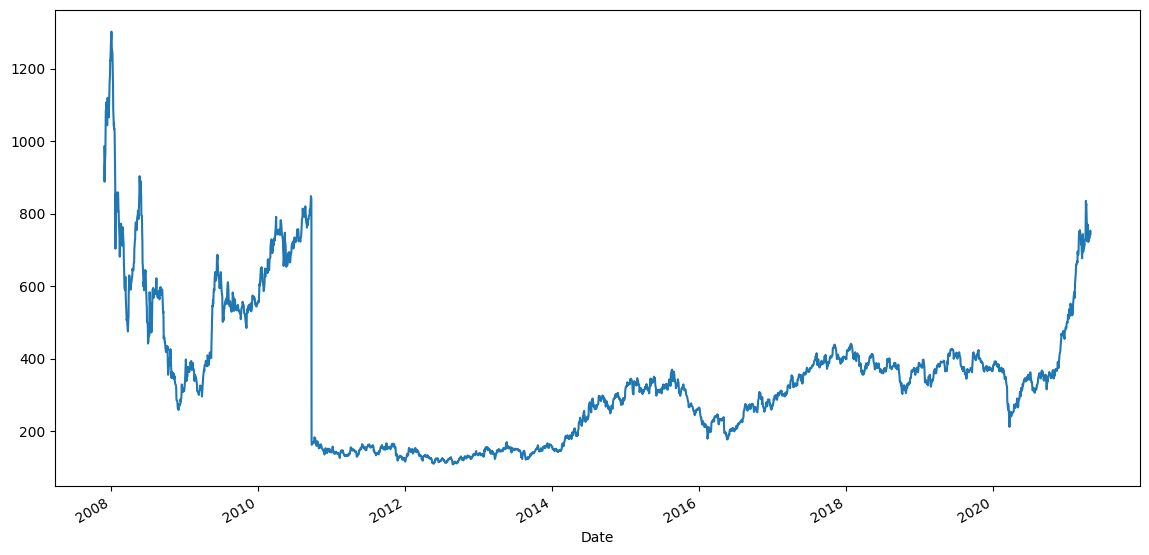

In [124]:
temp.VWAP.plot(figsize=(14, 7))

In [125]:
temp.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = temp[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = temp[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = temp[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    temp[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    temp[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    temp[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    temp[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    temp[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    temp[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

temp.fillna(temp.mean(), inplace=True)

temp.set_index("Date", drop=False, inplace=True)
temp.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,...,1.017670e+14,4.388344e+13,5.499181e+13,6.903394e+13,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891
2007-11-28,2007-11-28,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,...,2.687719e+15,4.388344e+13,5.499181e+13,6.903394e+13,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891
2007-11-29,2007-11-29,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,...,1.559498e+15,1.595546e+15,1.595546e+15,1.595546e+15,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891
2007-11-30,2007-11-30,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,...,1.191354e+15,1.295945e+15,1.295945e+15,1.295945e+15,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891
2007-12-03,2007-12-03,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,...,1.000597e+15,1.466104e+13,1.124812e+15,1.124812e+15,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891


In [127]:
temp.Date = pd.to_datetime(temp.Date, format="%Y-%m-%d")
temp["month"] = temp.Date.dt.month
temp["week"] = temp.Date.dt.isocalendar().week
temp["day"] = temp.Date.dt.day
temp["day_of_week"] = temp.Date.dt.dayofweek
temp.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-27,2007-11-27,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,...,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891,11,48,27,1
2007-11-28,2007-11-28,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,...,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891,11,48,28,2
2007-11-29,2007-11-29,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,...,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891,11,48,29,3
2007-11-30,2007-11-30,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,...,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891,11,48,30,4
2007-12-03,2007-12-03,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,...,44835.273438,44698.125,43112.871094,15035.652344,18072.902344,21278.712891,12,49,3,0


In [158]:
temp_train = temp[temp.Date < "2019"]
temp_valid = temp[temp.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      "month", "week", "day", "day_of_week"]

In [159]:
model = auto_arima(temp_train.VWAP, exogenous=temp_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(temp_train.VWAP, exogenous=temp_train[exogenous_features])

forecast = model.predict(n_periods=len(temp_valid), exogenous=temp_valid[exogenous_features])
#temp_valid["Forecast_ARIMAX"] = pd.Series(forecast, index=temp_valid.index)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23371.099, Time=6.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23389.058, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23368.403, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23368.819, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23387.499, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23370.389, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23370.394, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23370.957, Time=3.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23366.775, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23368.758, Time=1.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23368.765, Time=1.43 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23367.198, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23369.325, Time=1.74 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 16.824 seconds


In [160]:
temp_valid = temp_valid.copy()  # ensures it’s not a view
temp_valid["Forecast_ARIMAX"] = np.array(forecast)

# Check the first few values
print(temp_valid[["Forecast_ARIMAX"]].head())
print(forecast[:10])

            Forecast_ARIMAX
Date                       
2019-01-01       388.068182
2019-01-02       388.068925
2019-01-03       388.068993
2019-01-04       388.068999
2019-01-07       388.069000
2745    388.068182
2746    388.068925
2747    388.068993
2748    388.068999
2749    388.069000
2750    388.069000
2751    388.069000
2752    388.069000
2753    388.069000
2754    388.069000
dtype: float64


<Axes: xlabel='Date'>

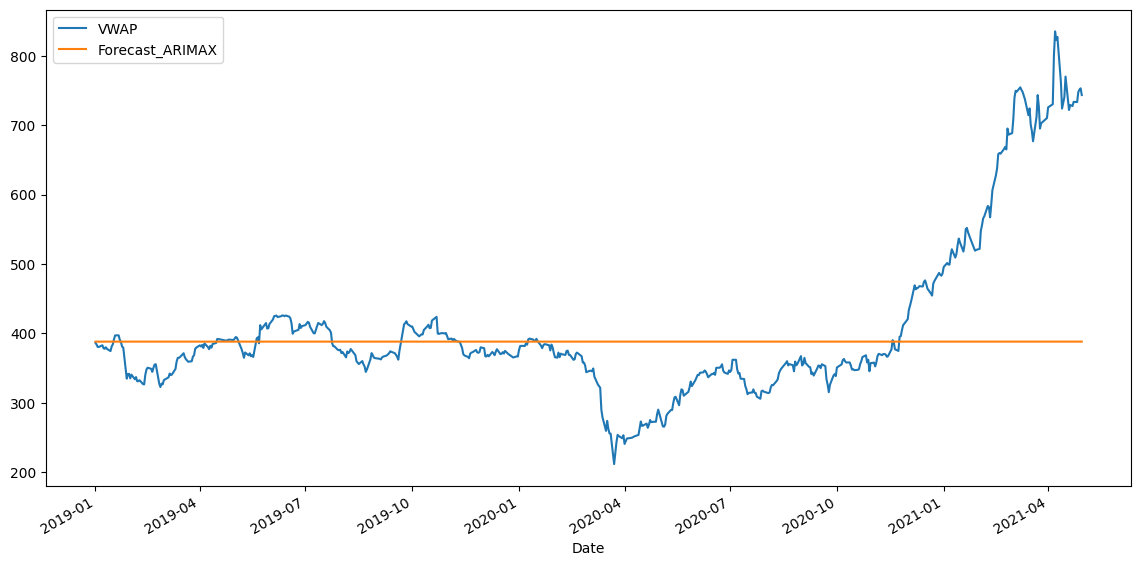

In [161]:
temp_valid[["VWAP", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [117]:
# # =========================================
# # 7. Model Selection (Example with ARIMA)
# # =========================================
# from statsmodels.tsa.arima.model import ARIMA

# # Use first difference if needed
# target_series = df['VWAP']

# # Split into train and test
# train_size = int(len(target_series) * 0.8)
# train, test = target_series[:train_size], target_series[train_size:]

# # Fit ARIMA
# model = ARIMA(train, order=(5,1,0))
# model_fit = model.fit()
# print(model_fit.summary())

# # =========================================
# # 8. Model Training & Hyperparameter Tuning
# # (Here we manually set order, but you could use auto_arima)
# # =========================================
# # Already trained above — you can loop through orders to tune

# # =========================================
# # 9. Model Evaluation
# # =========================================
# predictions = model_fit.forecast(steps=len(test))
# rmse = np.sqrt(mean_squared_error(test, predictions))
# mae = mean_absolute_error(test, predictions)
# mape = np.mean(np.abs((test - predictions) / test)) * 100

# print(f'RMSE: {rmse:.2f}')
# print(f'MAE: {mae:.2f}')
# print(f'MAPE: {mape:.2f}%')

# plt.figure(figsize=(12,5))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(test.index, predictions, label='Predicted')
# plt.legend()
# plt.title("VWAP Forecast vs Actuals")
# plt.show()

# # =========================================
# # 10. Forecasting
# # =========================================
# future_forecast = model_fit.forecast(steps=30)
# plt.figure(figsize=(10,4))
# plt.plot(target_series.index, target_series, label='Historical')
# plt.plot(pd.date_range(start=target_series.index[-1], periods=30, freq='D'),
#          future_forecast, label='Forecast')
# plt.legend()
# plt.title("30-Day VWAP Forecast")
# plt.show()
